In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, mixed_precision
from tensorflow.keras.layers import ReLU, RandomContrast, RandomTranslation, RandomFlip, RandomRotation, Input, LeakyReLU, Conv2D, Activation, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from pathlib import Path
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
import cv2 #pip install opencv-python
import numpy as np
from glob import glob 
from keras import backend as K
from contextlib import redirect_stdout
from keras.models import Model



PATH = 'G:/Deletar/pictures_conv'
tf.random.set_seed(42) 
PRECISION = tf.float32
HEIGHT = 128
WIDTH = 128
FILTERS = 128
KERNEL_SIZE = 3
STRIDES = 1
BATCH = 1
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 1002
IMG_RANGE = 255.
PC = 0

if (PC != 1):

    train_bw = glob("C:\\Deletar\\pictures_conv\\train_new\\bw\\*.jpg")
    train_color = glob("C:\\Deletar\\pictures_conv\\train_new\\color\\*.jpg")
    test_bw = glob("C:\\Deletar\\pictures_conv\\test_new\\bw\\*.jpg")
    test_color = glob("C:\\Deletar\\pictures_conv\\test_new\\color\\*.jpg")
else:
    train_bw = glob("G:\\Deletar\\pictures_conv\\train_new\\bw\\*.jpg")
    train_color = glob("G:\\Deletar\\pictures_conv\\train_new\\color\\*.jpg")
    test_bw = glob("G:\\Deletar\\pictures_conv\\test_new\\bw\\*.jpg")
    test_color = glob("G:\\Deletar\\pictures_conv\\test_new\\color\\*.jpg")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
# apply black and white colors to image
def apply_bw(filename):
    img = plt.imread(filename)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Input IMG is RGB
    img = cv2.merge([img,img,img])
    return img

def resize_image2(data):
    resized_img = tf.image.resize(
    images=K,
    size=[HEIGHT, WIDTH],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=True,
    )    
    return resized_img

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, PRECISION)
    img = tf.image.resize(img, size=(HEIGHT, WIDTH))
    return img

# read img and transform into tensor image
def read_img(filename):
    img = plt.imread(filename)
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])
    img = tf.convert_to_tensor(img/IMG_RANGE, dtype=PRECISION)
    return img

def get_all_info(folder):
    imgs = []
    for file in os.listdir(folder):
        img_tensor = read_img(folder + "\\" + file) 
    return imgs

""" z = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\bw") """

files_ds = tf.data.Dataset.from_tensor_slices((train_bw, train_color))
files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH).shuffle(BUFFER_SIZE)
val_files = tf.data.Dataset.from_tensor_slices((test_bw, test_color))
val_files = val_files.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)

example = list(files_ds.as_numpy_iterator())
example2 = list(val_files.as_numpy_iterator())



In [7]:
""" def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result """
  
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

""" def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result """

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=4,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

""" result.add(MaxPool2D((2, 2),  padding='same')) """

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model

    def on_epoch_end(self, epoch, logs={}):
      if epoch % 5 == 0: 
        z = self.model.predict(example[0][0])
        plt.imshow(z[0])
        plt.show()
        

Epoch 1/100
1/1 [==============================] - 0s 173ms/step - loss: 0.0374 - accuracy: 0.59


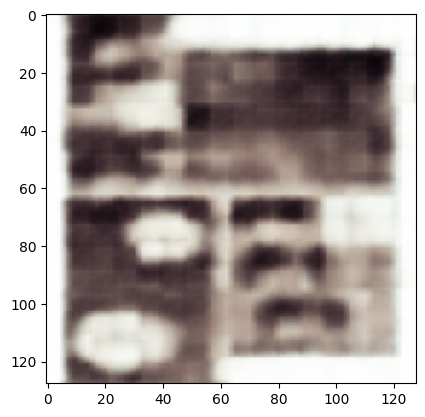

4996/4996 [==============================] - 183s 36ms/step - loss: 0.0374 - accuracy: 0.5973 - val_loss: 0.0243 - val_accuracy: 0.5574
Epoch 2/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0271 - accuracy: 0.5924 - val_loss: 0.0229 - val_accuracy: 0.6185
Epoch 3/100
4996/4996 [==============================] - 177s 35ms/step - loss: 0.0242 - accuracy: 0.5917 - val_loss: 0.0195 - val_accuracy: 0.5968
Epoch 4/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0226 - accuracy: 0.5917 - val_loss: 0.0189 - val_accuracy: 0.6031
Epoch 5/100
4996/4996 [==============================] - 182s 36ms/step - loss: 0.0213 - accuracy: 0.5918 - val_loss: 0.0182 - val_accuracy: 0.5980
Epoch 6/100
1/1 [==============================] - 0s 25ms/steps - loss: 0.0204 - accuracy: 0.59


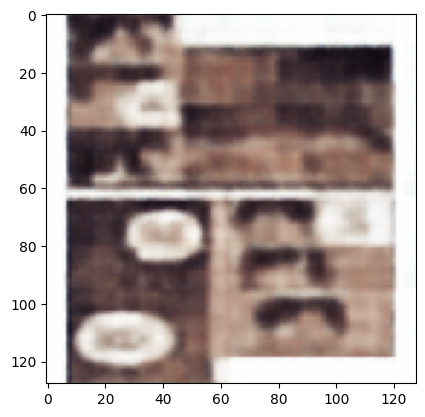

4996/4996 [==============================] - 180s 36ms/step - loss: 0.0204 - accuracy: 0.5908 - val_loss: 0.0177 - val_accuracy: 0.5957
Epoch 7/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0197 - accuracy: 0.5908 - val_loss: 0.0169 - val_accuracy: 0.6159
Epoch 8/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0191 - accuracy: 0.5893 - val_loss: 0.0167 - val_accuracy: 0.5892
Epoch 9/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0186 - accuracy: 0.5880 - val_loss: 0.0166 - val_accuracy: 0.6049
Epoch 10/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0182 - accuracy: 0.5873 - val_loss: 0.0172 - val_accuracy: 0.5979
Epoch 11/100
1/1 [==============================] - 0s 23ms/steps - loss: 0.0178 - accuracy: 0.58


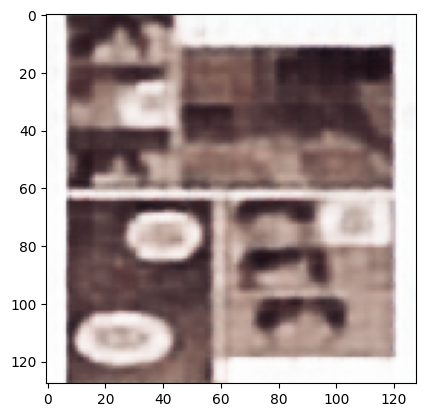

4996/4996 [==============================] - 179s 36ms/step - loss: 0.0178 - accuracy: 0.5877 - val_loss: 0.0161 - val_accuracy: 0.6086
Epoch 12/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0175 - accuracy: 0.5873 - val_loss: 0.0165 - val_accuracy: 0.5982
Epoch 13/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0172 - accuracy: 0.5873 - val_loss: 0.0154 - val_accuracy: 0.5303
Epoch 14/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0170 - accuracy: 0.5862 - val_loss: 0.0156 - val_accuracy: 0.5564
Epoch 15/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0168 - accuracy: 0.5857 - val_loss: 0.0163 - val_accuracy: 0.5811
Epoch 16/100
1/1 [==============================] - 0s 21ms/steps - loss: 0.0166 - accuracy: 0.58


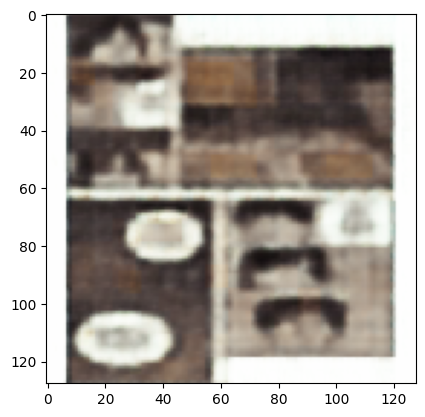

4996/4996 [==============================] - 179s 36ms/step - loss: 0.0166 - accuracy: 0.5844 - val_loss: 0.0155 - val_accuracy: 0.5347
Epoch 17/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0163 - accuracy: 0.5839 - val_loss: 0.0156 - val_accuracy: 0.5113
Epoch 18/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0162 - accuracy: 0.5836 - val_loss: 0.0155 - val_accuracy: 0.5871
Epoch 19/100
4996/4996 [==============================] - 178s 35ms/step - loss: 0.0160 - accuracy: 0.5845 - val_loss: 0.0160 - val_accuracy: 0.5988
Epoch 20/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0158 - accuracy: 0.5841 - val_loss: 0.0156 - val_accuracy: 0.6007
Epoch 21/100
1/1 [==============================] - 0s 20ms/steps - loss: 0.0156 - accuracy: 0.58


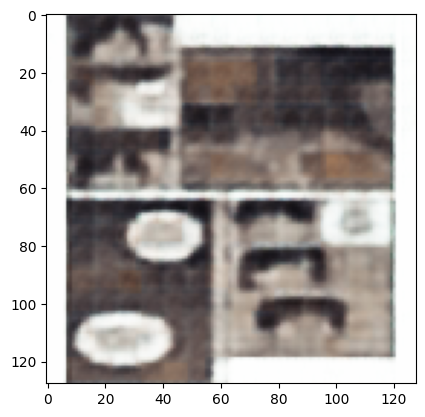

4996/4996 [==============================] - 178s 36ms/step - loss: 0.0156 - accuracy: 0.5861 - val_loss: 0.0154 - val_accuracy: 0.5384
Epoch 22/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0154 - accuracy: 0.5886 - val_loss: 0.0162 - val_accuracy: 0.6009
Epoch 23/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0153 - accuracy: 0.5901 - val_loss: 0.0164 - val_accuracy: 0.5967
Epoch 24/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0151 - accuracy: 0.5934 - val_loss: 0.0157 - val_accuracy: 0.5646
Epoch 25/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0149 - accuracy: 0.5959 - val_loss: 0.0158 - val_accuracy: 0.6048
Epoch 26/100
1/1 [==============================] - 0s 30ms/steps - loss: 0.0148 - accuracy: 0.59


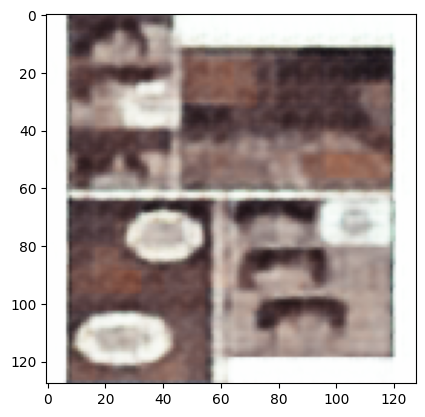

4996/4996 [==============================] - 180s 36ms/step - loss: 0.0148 - accuracy: 0.5965 - val_loss: 0.0158 - val_accuracy: 0.5609
Epoch 27/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0147 - accuracy: 0.5983 - val_loss: 0.0165 - val_accuracy: 0.5868
Epoch 28/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0145 - accuracy: 0.6003 - val_loss: 0.0164 - val_accuracy: 0.5590
Epoch 29/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0144 - accuracy: 0.6015 - val_loss: 0.0162 - val_accuracy: 0.5733
Epoch 30/100
4996/4996 [==============================] - 178s 36ms/step - loss: 0.0143 - accuracy: 0.6035 - val_loss: 0.0160 - val_accuracy: 0.5210
Epoch 31/100
1/1 [==============================] - 0s 23ms/steps - loss: 0.0141 - accuracy: 0.60


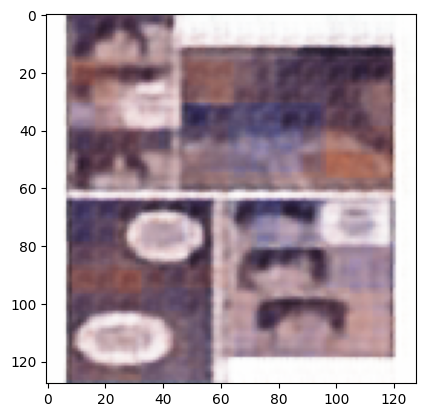

4996/4996 [==============================] - 178s 36ms/step - loss: 0.0141 - accuracy: 0.6041 - val_loss: 0.0192 - val_accuracy: 0.6053
Epoch 32/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0140 - accuracy: 0.6078 - val_loss: 0.0170 - val_accuracy: 0.6003
Epoch 33/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0138 - accuracy: 0.6078 - val_loss: 0.0175 - val_accuracy: 0.5712
Epoch 34/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0137 - accuracy: 0.6081 - val_loss: 0.0167 - val_accuracy: 0.5619
Epoch 35/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0136 - accuracy: 0.6115 - val_loss: 0.0173 - val_accuracy: 0.6014
Epoch 36/100
1/1 [==============================] - 0s 20ms/steps - loss: 0.0134 - accuracy: 0.61


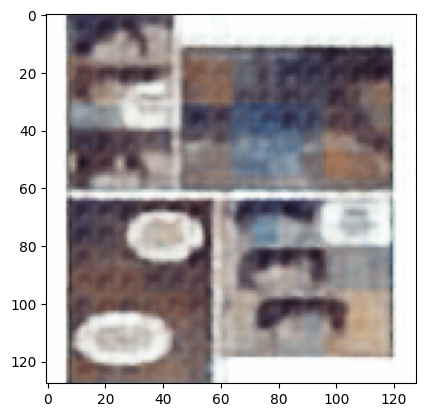

4996/4996 [==============================] - 180s 36ms/step - loss: 0.0134 - accuracy: 0.6126 - val_loss: 0.0170 - val_accuracy: 0.5424
Epoch 37/100
4996/4996 [==============================] - 179s 36ms/step - loss: 0.0133 - accuracy: 0.6146 - val_loss: 0.0181 - val_accuracy: 0.5760
Epoch 38/100
4996/4996 [==============================] - 180s 36ms/step - loss: 0.0132 - accuracy: 0.6172 - val_loss: 0.0174 - val_accuracy: 0.5583
Epoch 39/100
4996/4996 [==============================] - 180s 36ms/step - loss: 0.0131 - accuracy: 0.6186 - val_loss: 0.0185 - val_accuracy: 0.5681
Epoch 40/100
4996/4996 [==============================] - 180s 36ms/step - loss: 0.0129 - accuracy: 0.6210 - val_loss: 0.0182 - val_accuracy: 0.5869
Epoch 41/100
1/1 [==============================] - 0s 22ms/steps - loss: 0.0128 - accuracy: 0.62


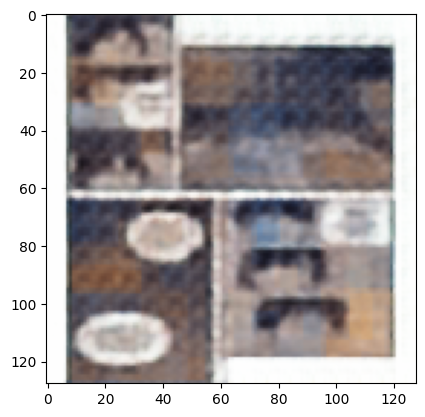

4996/4996 [==============================] - 180s 36ms/step - loss: 0.0128 - accuracy: 0.6214 - val_loss: 0.0191 - val_accuracy: 0.5818
Epoch 42/100
4996/4996 [==============================] - 181s 36ms/step - loss: 0.0127 - accuracy: 0.6232 - val_loss: 0.0197 - val_accuracy: 0.5763
Epoch 43/100
4996/4996 [==============================] - 181s 36ms/step - loss: 0.0126 - accuracy: 0.6255 - val_loss: 0.0186 - val_accuracy: 0.5973
Epoch 44/100
4996/4996 [==============================] - 181s 36ms/step - loss: 0.0125 - accuracy: 0.6267 - val_loss: 0.0195 - val_accuracy: 0.5953
Epoch 45/100
4996/4996 [==============================] - 182s 36ms/step - loss: 0.0124 - accuracy: 0.6272 - val_loss: 0.0188 - val_accuracy: 0.5964
Epoch 46/100
1/1 [==============================] - 0s 20ms/steps - loss: 0.0123 - accuracy: 0.62


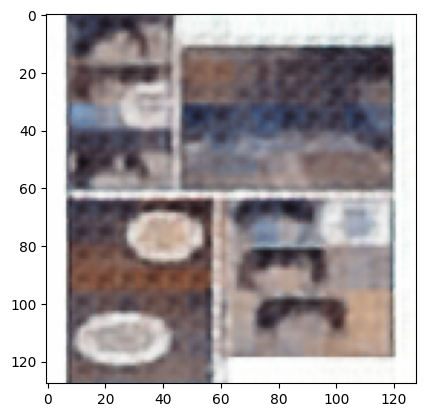

4996/4996 [==============================] - 182s 36ms/step - loss: 0.0123 - accuracy: 0.6299 - val_loss: 0.0207 - val_accuracy: 0.5700
Epoch 47/100
4996/4996 [==============================] - 181s 36ms/step - loss: 0.0122 - accuracy: 0.6312 - val_loss: 0.0192 - val_accuracy: 0.5849
Epoch 48/100
4996/4996 [==============================] - 181s 36ms/step - loss: 0.0122 - accuracy: 0.6323 - val_loss: 0.0197 - val_accuracy: 0.5917
Epoch 49/100
4996/4996 [==============================] - 182s 36ms/step - loss: 0.0121 - accuracy: 0.6321 - val_loss: 0.0189 - val_accuracy: 0.5591
Epoch 50/100
4996/4996 [==============================] - 182s 36ms/step - loss: 0.0120 - accuracy: 0.6338 - val_loss: 0.0194 - val_accuracy: 0.6095
Epoch 51/100
1/1 [==============================] - 0s 21ms/steps - loss: 0.0120 - accuracy: 0.63


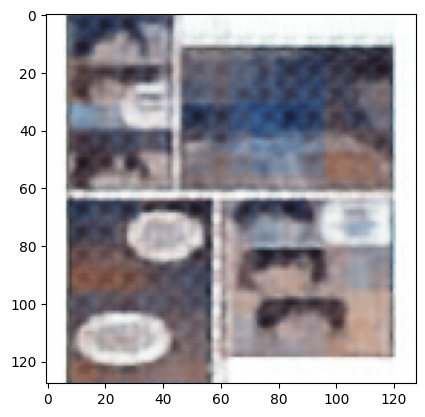

4996/4996 [==============================] - 182s 36ms/step - loss: 0.0120 - accuracy: 0.6351 - val_loss: 0.0186 - val_accuracy: 0.5414
Epoch 52/100
4995/4996 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.6351

In [8]:
initializer = tf.random_normal_initializer(0., 0.02)

# improvements
# insert layer kernel_regularizer='l1'
# insert layer kernel_regularizer='l2'

# model = model = 
# model.trainable = False

""" inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
x = inputs
x = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
x.trainable = False """

""" x = downsample(64,4, apply_batchnorm=False)(model.output) """

""" x = downsample(64,4, apply_batchnorm=False)(x)

model= x """
inputS=(HEIGHT, WIDTH, 3,)
model = Sequential()

""" model.add(Input(shape=(HEIGHT, WIDTH, 3,))) """
""" model.add(EfficientNetB0(input_shape=inputS, include_top=False, weights="imagenet")) """


""" for layer in model.layers:
  layer.trainable=False """

""" model.add(EfficientNetB0(input_shape=inputS, include_top=False, weights=None,))  """





#Encoder
""" model.add(downsample(64,4, apply_batchnorm=False))
model.add(downsample(128,4)) """

""" model.add(downsample(512,4, apply_batchnorm=False))
model.add(downsample(512,4))
model.add(downsample(512,4)) """
""" model.add(downsample(256,4, apply_batchnorm=False))
model.add(downsample(256,4)) """


""" model.add(downsample(1024,4, apply_batchnorm=False)) #best """

model.add(downsample(64,4, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(downsample(512,4))
model.add(downsample(512,4))
model.add(downsample(512,4))

#Decoder
""" model.add(upsample(512,4, apply_dropout=True))
model.add(upsample(512,4, apply_dropout=True)) """

""" model.add(upsample(256,4, apply_dropout=True)) """


""" model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh'))  """


""" model.add(Activation('tanh')) """
""" model.add(Activation('sigmoid')) """


""" model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same')) """

model.add(upsample(256,4, apply_dropout=True))
model.add(upsample(128,4))
""" model.add(upsample(64,4))
model.add(upsample(32,4)) """
""" model.add(Activation('sigmoid')) """


model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='sigmoid',
                                          ))


model.compile(
    # loss
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanSquaredError(),

    # optimizer    
    #optimizer= tf.keras.optimizers.Adam(2e-3, beta_1=0.5),
    # optimizer= tf.keras.optimizers.RMSprop(),

    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=1e-2)),
    metrics=["accuracy"]    
)

""" callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True) """
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9999, restore_best_weights=True)
 

model.fit(files_ds,epochs=100, callbacks=[CustomCallback(model, files_ds), callback], validation_data=val_files)


model.summary() 


In [1]:
test_img_pred = model.predict(example2[0][0])[0]
test_img_pred2 = model.predict(example2[1][0])[0]
test_img_pred3 = model.predict(example2[2][0])[0]
train_img_pred = model.predict(example[0][0])[0]

f, axarr = plt.subplots(2,6, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)
axarr[0,0].imshow(example2[0][0][0])
axarr[0,1].imshow(example2[0][1][0])
axarr[0,2].imshow(test_img_pred)
axarr[0,3].imshow(example2[1][0][0])
axarr[0,4].imshow(example2[1][1][0])
axarr[0,5].imshow(test_img_pred2)

axarr[1,0].imshow(example2[2][0][0])
axarr[1,1].imshow(example2[2][1][0])
axarr[1,2].imshow(test_img_pred3)
axarr[1,3].imshow(example[0][0][0])
axarr[1,4].imshow(example[0][1][0])
axarr[1,5].imshow(train_img_pred)



NameError: name 'model' is not defined

In [ ]:
#comments

""" model = Sequential([
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_01'),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_01'),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_02'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_02'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_03'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_04'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_04'),
    Dropout(0.5),
    Activation('relu', name='relu_04'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_05'),
    Dropout(0.5),
    Activation('relu', name='relu_05'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_06'),
    Activation('relu', name='relu_06'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same'),
    Activation('tanh'),    
]) """

# model.add(Input(shape=[HEIGHT, WIDTH, 3]))

""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(upsample(128,4, apply_dropout=True)) """

""" model = Sequential()
model.add(downsample(64,9, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(upsample(128,4, apply_dropout=True))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """

""" model.add(downsample(128,4)) """
""" model.add(downsample(256,4)) """
""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(downsample(128,4)) """
""" model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) """

""" model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """


""" model.add(upsample(128,4, apply_dropout=True))
model.add(upsample(128,4, apply_dropout=True)) """
""" model.add(upsample(128,4))
model.add(upsample(128,4)) """
""" model.add(upsample(256,4, apply_dropout=True)) """
""" model.add(upsample(128,4)) """


""" 
model.add(UpSampling2D((2, 2))) """

""" encoder_output = (encoder_input)



decoder_output = (encoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output) """


' encoder_output = (encoder_input)\n\n\n\ndecoder_output = (encoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output) '